# Hierarchické zhlukovanie a k-means

## Supervizované a nesupervizované učenie
- **Supervizované učenie:** typ učenia, ktorý sme preberali na predchádzajúcich cvičeniach
    - k hodnotám príznakov poznáme v trénovacích dátach aj správnu hodnotu predikovanej premennej
    - sme schopní spočítať akej chyby sa náš model dopustil
    - na základe tejto chyby vykonávame zmeny modelu
    
    $
    X = \begin{pmatrix}
    x_{1,1} & x_{1,2} & x_{1,3} \\
    x_{2,1} & x_{2,2} & x_{2,3} \\
    x_{3,1} & x_{3,2} & x_{3,3} \\
    \end{pmatrix},
    Y = \begin{pmatrix}
    y_{1} \\
    y_{2} \\
    y_{3} \\
    \end{pmatrix},
    \hat{Y} = \begin{pmatrix}
    \hat{y_{1}} \\
    \hat{y_{2}} \\
    \hat{y_{3}} \\
    \end{pmatrix}
    $

- **Nesupervizované učenie:** tomuto typu sa budeme venovať na dnešnom cvičení
    - máme iba hodnoty príznakov (zväčša číselného charakteru)
    - snažíme sa porozumieť štruktúre dát
    - žiadna metrika, ktorá by udávala kvalitu modelu
    
    $
    X = \begin{pmatrix}
    4.96212 & 7.11146 & 6.39075 \\
    3.41456 & 3.68899 & 3.80299 \\
    2.38974 & 4.09303 & 3.08043 \\
    5.58413 & 6.01418 & 4.84987 \\
    4.57572 & 2.62833 & 3.57272
    \end{pmatrix}
    $

![img/fig_3d_points.png](img/fig_3d_points.png)

![img/fig_3d_points_colored.png](img/fig_3d_points_colored.png)

 V tomto notebooku si budeme hrát se shlukováním.
 
 * Nejprve si na umělých datech vyzkoušíme hierarchické shlukování a algoritmus k-means, abychom si obě metody osahali.
 * Potom provedeme hierarchické shlukování na datasetu Iris (3 druhy kosatců) a podíváme se jak nalezené shluky odpovídají reálným druhům.
 * Nakonec se podíváme na vektorovou kvantizaci obrázků jakožto zajímavou aplikaci algoritmu k-means.

## Generovanie umelých dát

Pre ukážku fungovania hierarchického zhlukovania si umelo nagenerujeme dáta, ktoré patria do nejakého rozdelenia.

Dáta generujeme z 3 rôznych **viacrozmerných normálnych rozdelení.**

Parametre tohto rozdelenia sú:
* vektor stredných hodnôt (zodpovedá stredu výsledného zhluku)
* variačná matica (zodpovedá tvaru, kruh alebo nejakým spôsobom natočená elipsa)

Dodatočný parameter funkcie balíka `numpy`:
* veľkosť vygenerovaného zhluku

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # potlačení výpisu floatů (tak aby 0.000 bylo zobrazeno jako 0.)

In [2]:
# generování tří shluků: a se 60 body, b se 40 body, c s 20:
np.random.seed(42)  # zajistí replikovatelnost
a = np.random.multivariate_normal([7, 7], [[2, 0.5], [0.5, 2]], size=[60,])
b = np.random.multivariate_normal([0, 15], [[2, 0], [0, 2]], size=[40,])
c = np.random.multivariate_normal([15, 0], [[3, 1], [1, 4]], size=[20,])

# spojení shluků do X
X = np.concatenate((a, b, c),)

# zobrazení velikosti výsledných dat
print(X.shape)

(120, 2)


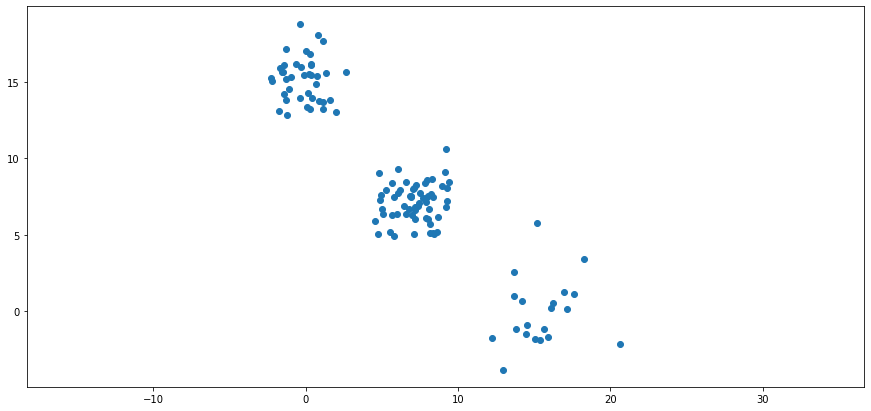

In [3]:
# zobrazení výsledných dat
plt.figure(figsize=(15, 7))
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

## Aglomerativní hierarchické shlukování

Použijeme knihovnu `scipy`, konkrétně balíček hierarchického shlukování `scipy.cluster.hierarchy`. [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

Tato část notebooku je inspirována [tímto příspěvkem na blogu](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

### Matice propojení

Pro její sestavení použijeme funkci `linkage`. [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

* Důležitým argumentem je volba metody, kterou se měří vzdálenosti shluků.
* Nyní použijeme metodu nejbližšího souseda - **single linkage**. Později si můžete hrát i s těmi ostatními:
    - complete linkage,
    - average linkage,
    - wardova metoda.
    
* Vieme špecifikovať aj metriku, pomocou ktorej sa má vzdialenosť počítať. [(zoznam tu)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
    - východzia je euklidovská vzdialenosť
    - manhattanská vzdialenosť = `cityblock`

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

# spočteme tzv. matici propojení
Z = linkage(X, method="single", metric="euclidean")

# rozměry výstupu
print(Z.shape)

(119, 4)


Výstupem je matice propojení (linkage matrix), ve které každý řádek odpovídá jednomu spojení shluků do nového shluku. 
Sloupce jsou:
* index prvního spojovaného shluku
* index druhého spojovaného shluku
* vzdálenost mezi spojovanými shluky
* počet bodů, které jsou v nově vytvořeném shluku

In [5]:
# Podívejme se na prvních 5 řádků Z
print(Z[:5,:])

[[66.      91.       0.01747  2.     ]
 [72.      87.       0.06841  2.     ]
 [ 6.      18.       0.07725  2.     ]
 [40.      57.       0.0806   2.     ]
 [ 4.      44.       0.10185  2.     ]]


Obvzláště si všimněte třetího řádku, kde má jeden ze spojovaných shluků index 120, což je ve skutečnosti první shluk vytvořený spojením.

### Vizualizace plného dendrogramu

Použijeme funkci `dendrogram` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram).

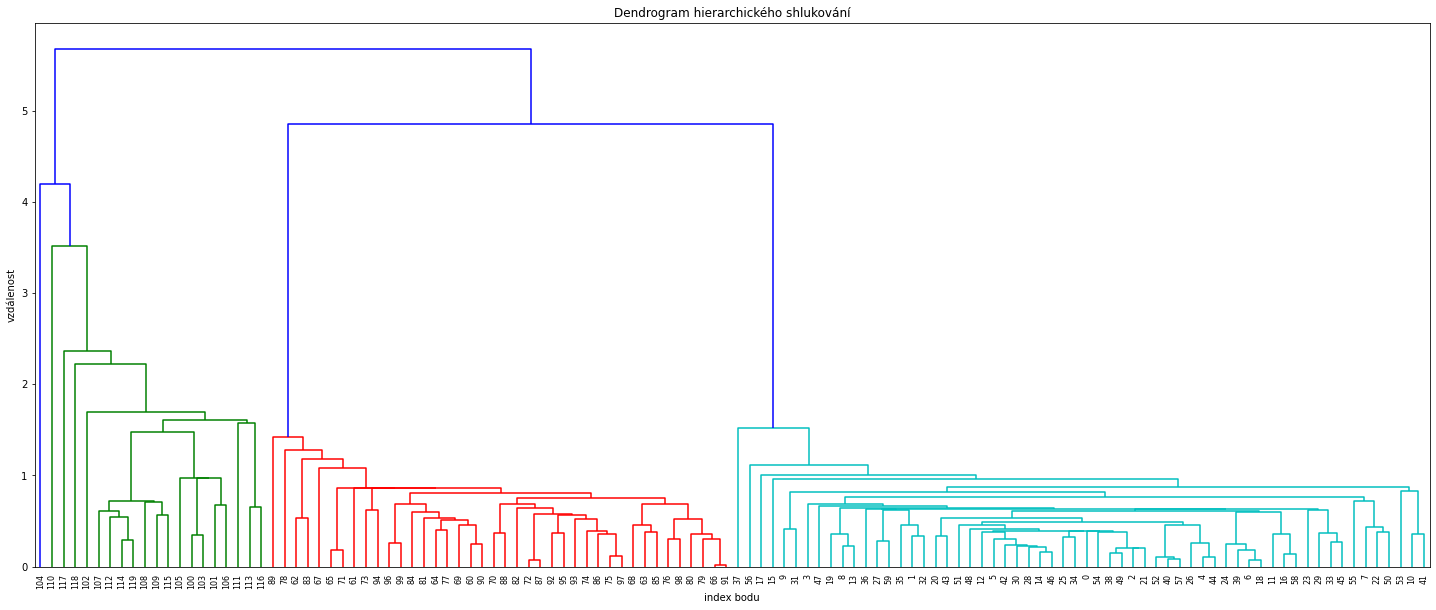

In [6]:
plt.figure(figsize=(25, 10))
plt.title("Dendrogram hierarchického shlukování")
plt.xlabel("index bodu")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    leaf_rotation=90.,  # otočení popisů x-ové osy
    leaf_font_size=8.,  # velikost fontu popisů x-ové osy
)

plt.show()

![img/figure_dendrogram.png](img/figure_dendrogram.png)

Všimněte si, že:
* horizontální čáry odpovídají spojením shluků
* vertikální čáry nám říkají, které shluky se do nového shluku spojují
* výšky (tj. y-ové pozice) horizontálních čar odpovídají vzdálenosti mezi spojovanými shluky

### Vizualizácia orezaného dendrogramu

Zobrazíme iba hornú časť dendrogramu, kde dochádza k spájaniu posledných, veľkých zhlukov.

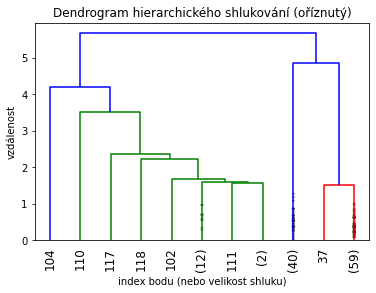

In [7]:
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",  # Zobraz jenom posledních p spojených shluků
    p=11,  # Nastavení tohto p
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # pomáhá vizuální představě o spojování vedoucí k těm uříznutým shlukům 
    # (čárky na spodních vertikálních čárách).
)

plt.show()

### Dendrogram s vzdialenosťou

S využitím: [annotating the distances inside the dendrogram](https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib/12311618#12311618)

In [8]:
def distance_dendrogram(*args, **kwargs):
    # pop arguments which are not expected by dendrogram function
    max_d = kwargs.pop("max_d", None)
    annotate_if_above = kwargs.pop("annotate_if_above", 0.0)
    
    if max_d and "color_threshold" not in kwargs:
        kwargs["color_threshold"] = max_d
    
    plt.title("Dendrogram hierarchického shlukování se vzdáleností")
    plt.xlabel("index bodu (nebo velikost shluku)")
    plt.ylabel("vzdálenost")
    
    # create the dendrogram
    ddata = dendrogram(*args, **kwargs)

    for i, d, c in zip(ddata["icoord"], ddata["dcoord"], ddata["color_list"]):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        # if the annotation value is above the threshold
        if y > annotate_if_above:
            # plot a point at given x, y position
            plt.plot(x, y, "o", c=c)
            # show an annotation by the plotted point
            plt.annotate(
                "%.3g" % y, (x, y), xytext=(0, -5), textcoords="offset points", va="top", ha="center"
            )
    
    # show a horizontal line
    if max_d:
        plt.axhline(y=max_d, c="k")

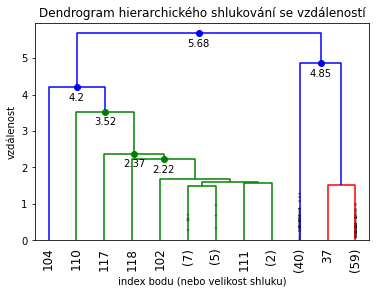

In [9]:
distance_dendrogram(
    Z,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)

plt.show()

## Extrakce shlukování z matice prepojení
K tomu využijeme funkci `fcluster` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster).

### Poznáme výšku rezu

Výška rezu je hranica pre vzdialenosť zhlukov, nad ktorú už nebudeme zhluky spájať.

In [10]:
from scipy.cluster.hierarchy import fcluster

max_d = 5

clusters = fcluster(Z, max_d, criterion="distance")

print(clusters)  # výpis shlukování

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


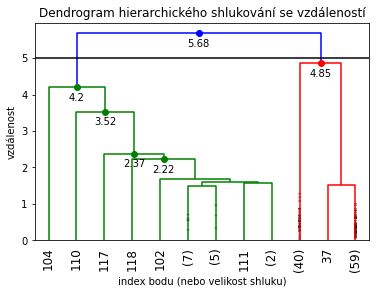

In [11]:
distance_dendrogram(
    Z,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,
    max_d=max_d,
)

plt.show()

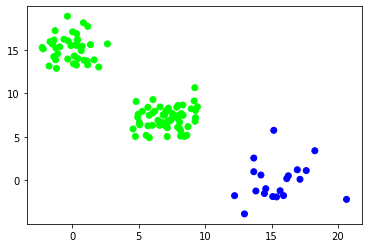

In [12]:
plt.scatter(X[:,0], X[:,1], c=clusters, cmap="brg")  # plot points with cluster dependent colors
plt.show()

### Poznáme požadovaný počet zhlukov $k$

In [13]:
k = 3

k_clusters = fcluster(Z, k, criterion="maxclust")

# výpis shlukování\
print(k_clusters)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


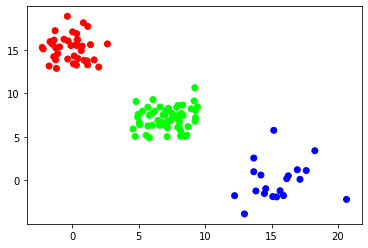

In [14]:
plt.scatter(X[:,0], X[:,1], c=k_clusters, cmap="brg")
plt.show()

### Algoritmus $k$-means 
Použijeme sekci `clustering` z knihovny `sklearn` [(dokumentace zde)](http://scikit-learn.org/stable/modules/clustering.html#k-means).

Konkrétně použijeme funkci `Kmeans` [(dokumentace zde)](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[[-0.14334 15.19093]
 [ 9.24695  5.31228]]


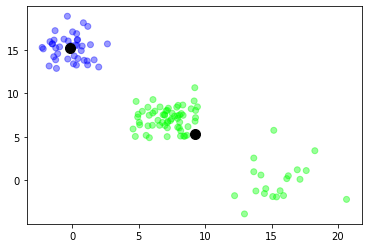

In [15]:
from sklearn.cluster import KMeans

# Nejdřív zkusme 2 shuky
k = 2
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# výsledné shluky
print(kmeans.labels_)
# a jejich středy
print(kmeans.cluster_centers_)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

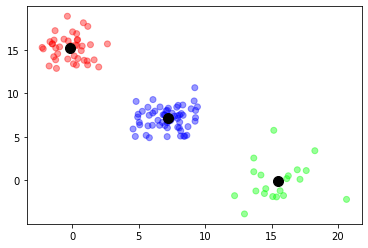

In [16]:
# To stejné pro 3shluky
k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

V defaultním nastavení probíhá inicializace středů "chytrým" způsobem, `init = 'k-means++'` [David, Vassilvitskii (2007)](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), a běh algoritmu se opakuje 10 krát, `n_init = 10`.

Finálním výstupem je pak výstup nějlepšího běhu (nejmenší hodnota účelové funkce výsledku).

Kromě této "chytré" inicializace je možné použít klasickou náhodnou inicializaci (náhodný výběr z dat) nebo dokonce určit počáteční středy manuálně.

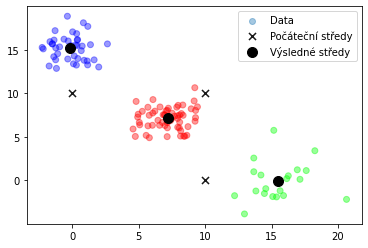

In [17]:
k = 3
# manuální inicializace
initial_centers = np.array([[0,10],[10,10],[10,0]])

# shlukování
kmeans = KMeans(n_clusters = k, random_state = 1, init = initial_centers, n_init = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(initial_centers[:,0], initial_centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # initial centers
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100) # final centers
plt.legend(['Data', 'Počáteční středy', 'Výsledné středy'])
plt.show()

### Algoritmus $k$-means můžeme z důvodu "osahání" jednoduše implementovat ručně

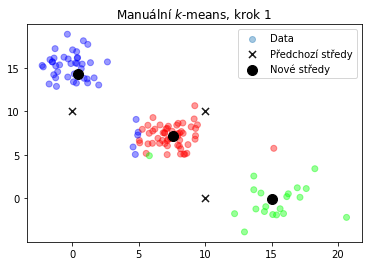

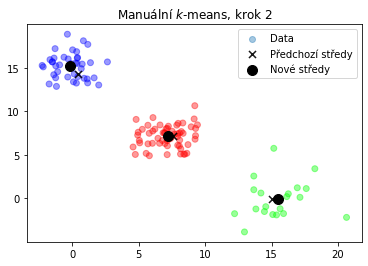

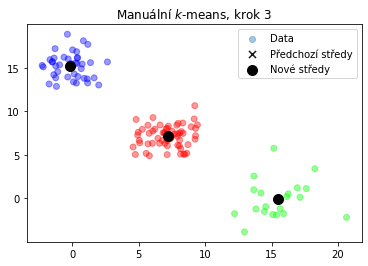

In [18]:
from sklearn.metrics import pairwise_distances_argmin
centers = initial_centers
for i in range(3):
    y_pred = pairwise_distances_argmin(X, centers)
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(len(centers))])

    # Obrázek
    plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
    plt.scatter(centers[:,0], centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # old centers
    plt.scatter(new_centers[:,0], new_centers[:,1], c = 'black', s=100) # new centers
    plt.title('Manuální $k$-means, krok ' + str(i+1))
    plt.legend(['Data', 'Předchozí středy', 'Nové středy'])
    plt.show()
    
    centers = new_centers

### Určování optimální hodnoty $k$
Zobrazíme hodnotu účelové funkce vzávislosti na $k$ a budeme hledat bod zlomu (loket).

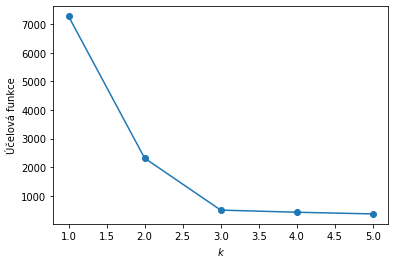

In [19]:
ix = np.zeros(5)
iy = np.zeros(5)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

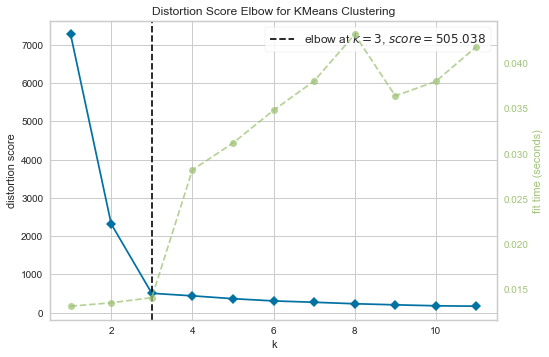

In [20]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Úkol 1 - proveďte hierarchické shlukování na Iris datasetu
* Hledejte 3 shluky
* Diskutujte a kvantifikujte vhodným způsobem kvalitu výsledných shluků ve vztahu ke skutečným druhým kosatců (Setosa, Versicolour a Virginica), které jsou uložené vproměnné y.
* Zkuste najít nejlepší metodu měření vzdáleností shluků, aby získané shluky nejvíce odpovídaly skutečným druhům kosatců.

In [21]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

print('X shape:', X.shape)

X shape: (150, 4)


* Podíváme se na obsah dat

In [22]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

* Ohadneme optimální počet shluků pomocí elbow grafu
    * Všimněte si, že i když víme že shluky by měli být 3, z elbow grafu se zdá že optimální počet jsou 2

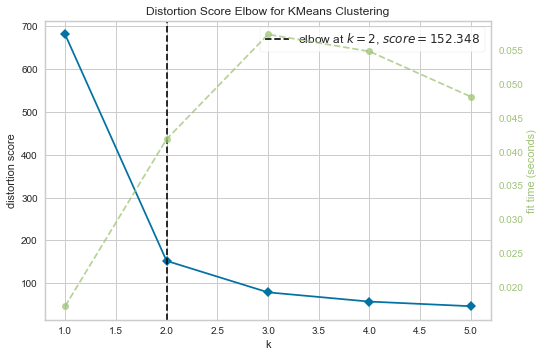

In [23]:
## Váš kód napište sem
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,6))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

* Zkusíme KMeans se skutečným optimem (3 shluky)

In [24]:
model = KMeans(n_clusters=3)

model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

* Vizualizujeme v grafu
    * Jelikož máme 4 dimenzionální data, nemáme optimální způsob jak je vizualizovat
    * Vizualizujeme tedy jednotlivé kombinace dvou příznaků v 2D scatter grafech

In [26]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # To ignore deprecation warnings

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


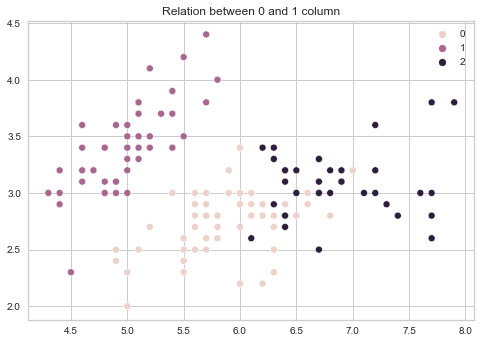

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


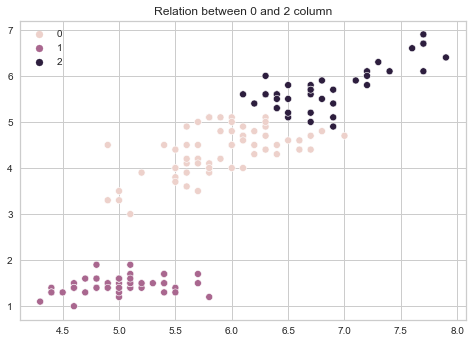

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


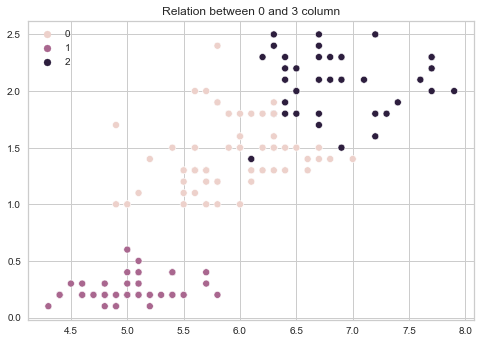

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


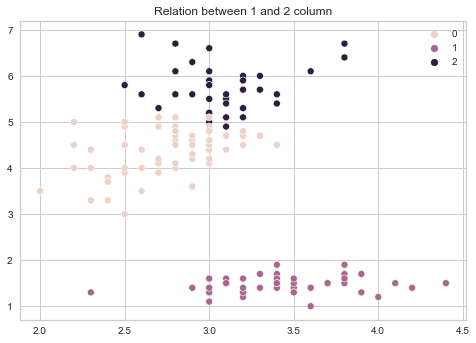

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


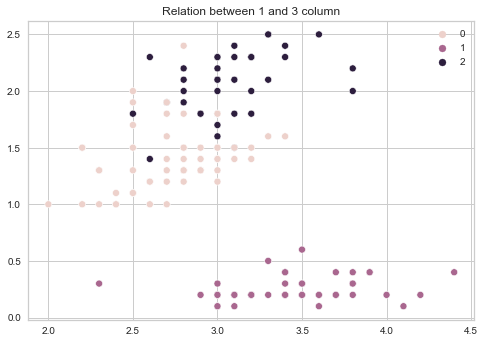

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


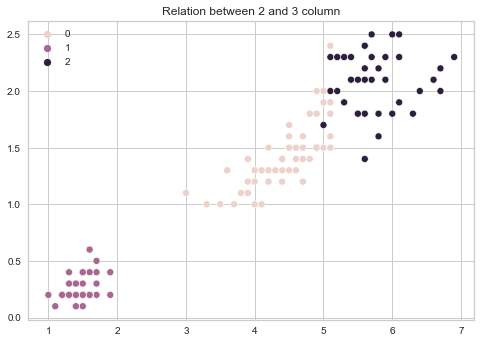

In [27]:
for i in range(0, X.shape[1]):
    for j in range(i+1, X.shape[1]):
        if i!=j:
            sns.scatterplot(X[:, i], X[:, j], hue=model.labels_)
            plt.title("Relation between {} and {} column".format(i,j))
            plt.show()

### Úkol 2 - proveďte vektorovou kvantizaci obrázku pomocí algoritmu $k$-means
Je třeba instalovat balíček Pillow
`pip install Pillow`. [(dokumentace zde)](https://pillow.readthedocs.io/en/5.3.x/index.html)

Nejprve úvodní část kódu, která nás dovede na začátek vlastního problému.

Shape of the array: (341, 512)


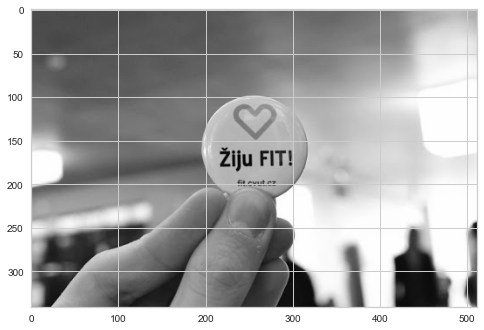

In [28]:
from PIL import Image
# otevření a převedení do stupňů šedi
im = Image.open("figure.jpg").convert("L")
# normalizace numpy array na čísla mezi 0 a 1
pix = np.array(im)/255.0
print('Shape of the array:', pix.shape)
# Zobrazení
plt.imshow(pix, cmap="gray", clim=(0, 1));
plt.show()

Vlastní úkol:
* ořízněte obrázek tak, aby jeho šířka byla násobkem 4
* vytvořte sloupcové bločky délky 4 - tj. části z originálního obrázku s rozměry (1,4).
* proveďte shlukování pomocí k-means s k = 255 shluky - tj. bude stačit jeden bajt na přenesení informace o příslušnosti ke shluku
* extrahujte středy bloků a labely - tj. indexy příslušnosti originálních bločků k jednotlivým shlukům
* dekódujte je zpět do pole s rozměrem originálního obrázku - **hint** - využijte: `restored = np.take(centroids, labels, axis = 0)`
* zobrazte výsledek
* diskutujte redukci velikost pokud použijeme reprezentaci původního obrázku pomocí středů a labelů.

In [29]:
pix

array([[0.29804, 0.29804, 0.29804, ..., 0.68627, 0.68235, 0.68235],
       [0.29804, 0.29804, 0.29804, ..., 0.68627, 0.68235, 0.68235],
       [0.29804, 0.29804, 0.29804, ..., 0.68627, 0.68235, 0.68235],
       ...,
       [0.6902 , 0.71373, 0.72157, ..., 0.3098 , 0.27059, 0.26275],
       [0.65098, 0.67843, 0.68235, ..., 0.39216, 0.32941, 0.29412],
       [0.61961, 0.64706, 0.65098, ..., 0.47451, 0.41569, 0.36863]])

In [30]:
## Váš kód napište sem

# set block length to 4
block_len = 96

In [31]:
rows, cols = pix.shape
pix = pix[:, :(cols - cols % block_len)]
print(pix.shape)

(341, 480)


In [32]:
X  = pix.reshape(-1, block_len)
print(X.shape)

(1705, 96)


In [33]:
X

array([[0.29804, 0.29804, 0.29804, ..., 0.29804, 0.30196, 0.30196],
       [0.29804, 0.29804, 0.29804, ..., 0.32941, 0.32941, 0.32941],
       [0.32549, 0.32549, 0.32549, ..., 0.39608, 0.39608, 0.39608],
       ...,
       [0.56863, 0.56078, 0.55294, ..., 0.06275, 0.06275, 0.0549 ],
       [0.06275, 0.06275, 0.06275, ..., 0.46275, 0.6549 , 0.76471],
       [0.85882, 0.89412, 0.92941, ..., 0.38824, 0.59608, 0.72549]])

The indivdual centroids (150, 96)
How many points were classified (1705,)


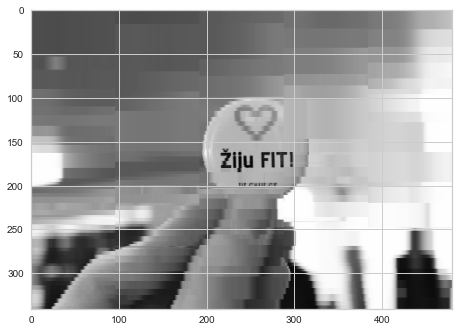

In [34]:
from sklearn.cluster import KMeans

# Number of clusters
K = 150

kmeans = KMeans(n_clusters=K).fit(X)

_centroids = kmeans.cluster_centers_
_labels = kmeans.labels_
print("The indivdual centroids", _centroids.shape)
print("How many points were classified", _labels.shape)

# restore the compressed image from centroids and labels
restored = np.take(_centroids, _labels, axis=0)
final_pix = restored.reshape(pix.shape)

# visualize a result
plt.imshow(final_pix, cmap="gray", clim=(0, 1));
plt.show()

# Bonus
(inšpirácia: https://www.instagram.com/colorpalette.cinema)

[<img src="https://i.imgur.com/VLEXeQi.png">]()

Z obrázka pomocou clusteringu môžete tak isto získať "hlavné farby". Podobne ako na IG profile, ktorý mi bol inšpiráciou.


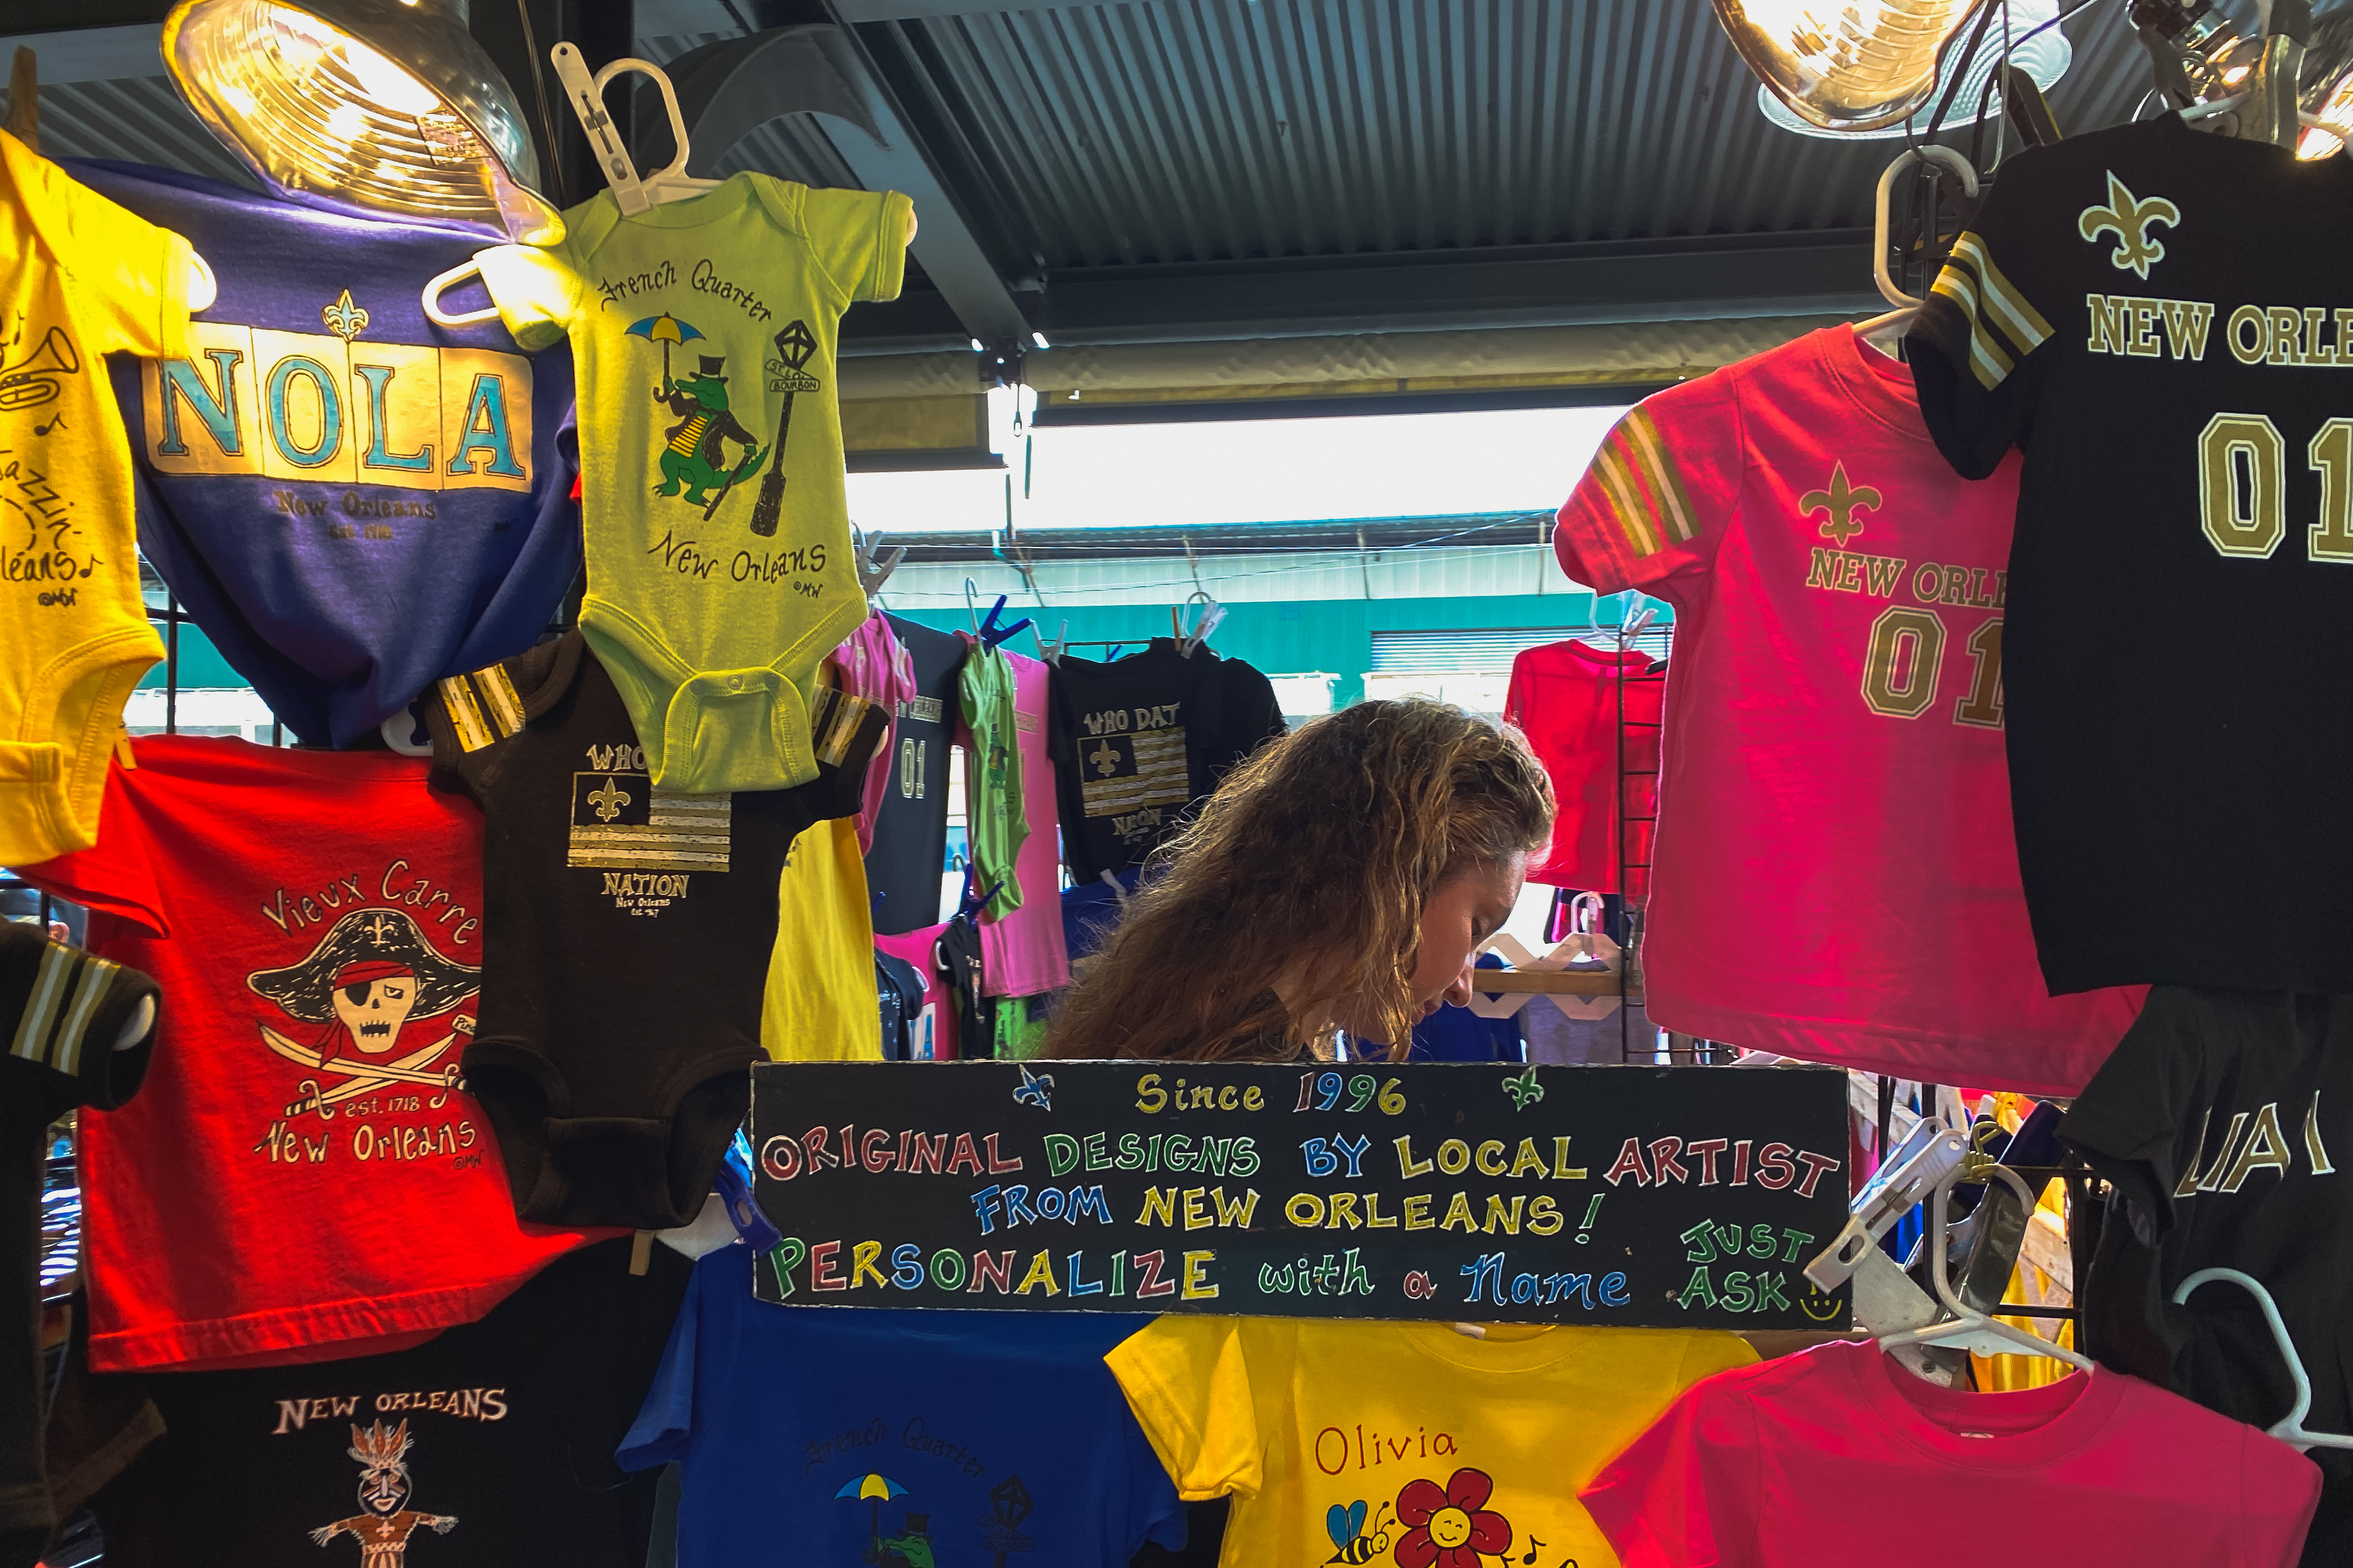

In [35]:
from IPython.display import Image
Image(filename='test.jpg') 

In [36]:
#https://stackoverflow.com/questions/8915113/sort-hex-colors-to-match-rainbow
#transfer to hue, staturation, value
def get_hsv(hexrgb):
    hexrgb = hexrgb.lstrip('#')   # in case you have Web color specs
    r, g, b = (int(hexrgb[i:i+2], 16) / 255.0 for i in range(0,5,2))
    return colorsys.rgb_to_hsv(r, g, b)

In [37]:
from matplotlib.image import imread
from sklearn.cluster import KMeans
from matplotlib.colors import to_hex
from PIL import Image
import colorsys
import os

img = Image.open('test.jpg')
img = img.resize((1008,756), Image.ANTIALIAS)
img.save('resized.jpg') 

palette_size = 10

#load image
img = imread('resized.jpg')

#get image dimensions
w, h, d = original_shape = tuple(img.shape)

#set RGB
assert d == 3

#transform to 2D array
image_array = np.reshape(img, (w * h, d))
image_array = image_array/255 #normalizacia
km = KMeans(n_clusters=palette_size, n_init=10, max_iter=300).fit(image_array)

color_list = []

for c in km.cluster_centers_:
    color_list.append(to_hex(c))

color_list.sort(key=get_hsv)
# print(color_list)

boxes = []
for c in color_list:
    boxes.append(Image.new("RGB", (210,210), c))

out = Image.new('RGB', (4032, 3024), 'white')
img = Image.open('test.jpg')
img = img.resize((3024,2268), Image.ANTIALIAS)

out.paste(img, (504, 223))

margin = 0
for b in boxes:
    new_x = 866+margin
    out.paste(b, (new_x,2591))
    margin += 20 + 210

os.remove("resized.jpg") 
out.save('test_palette.jpg')

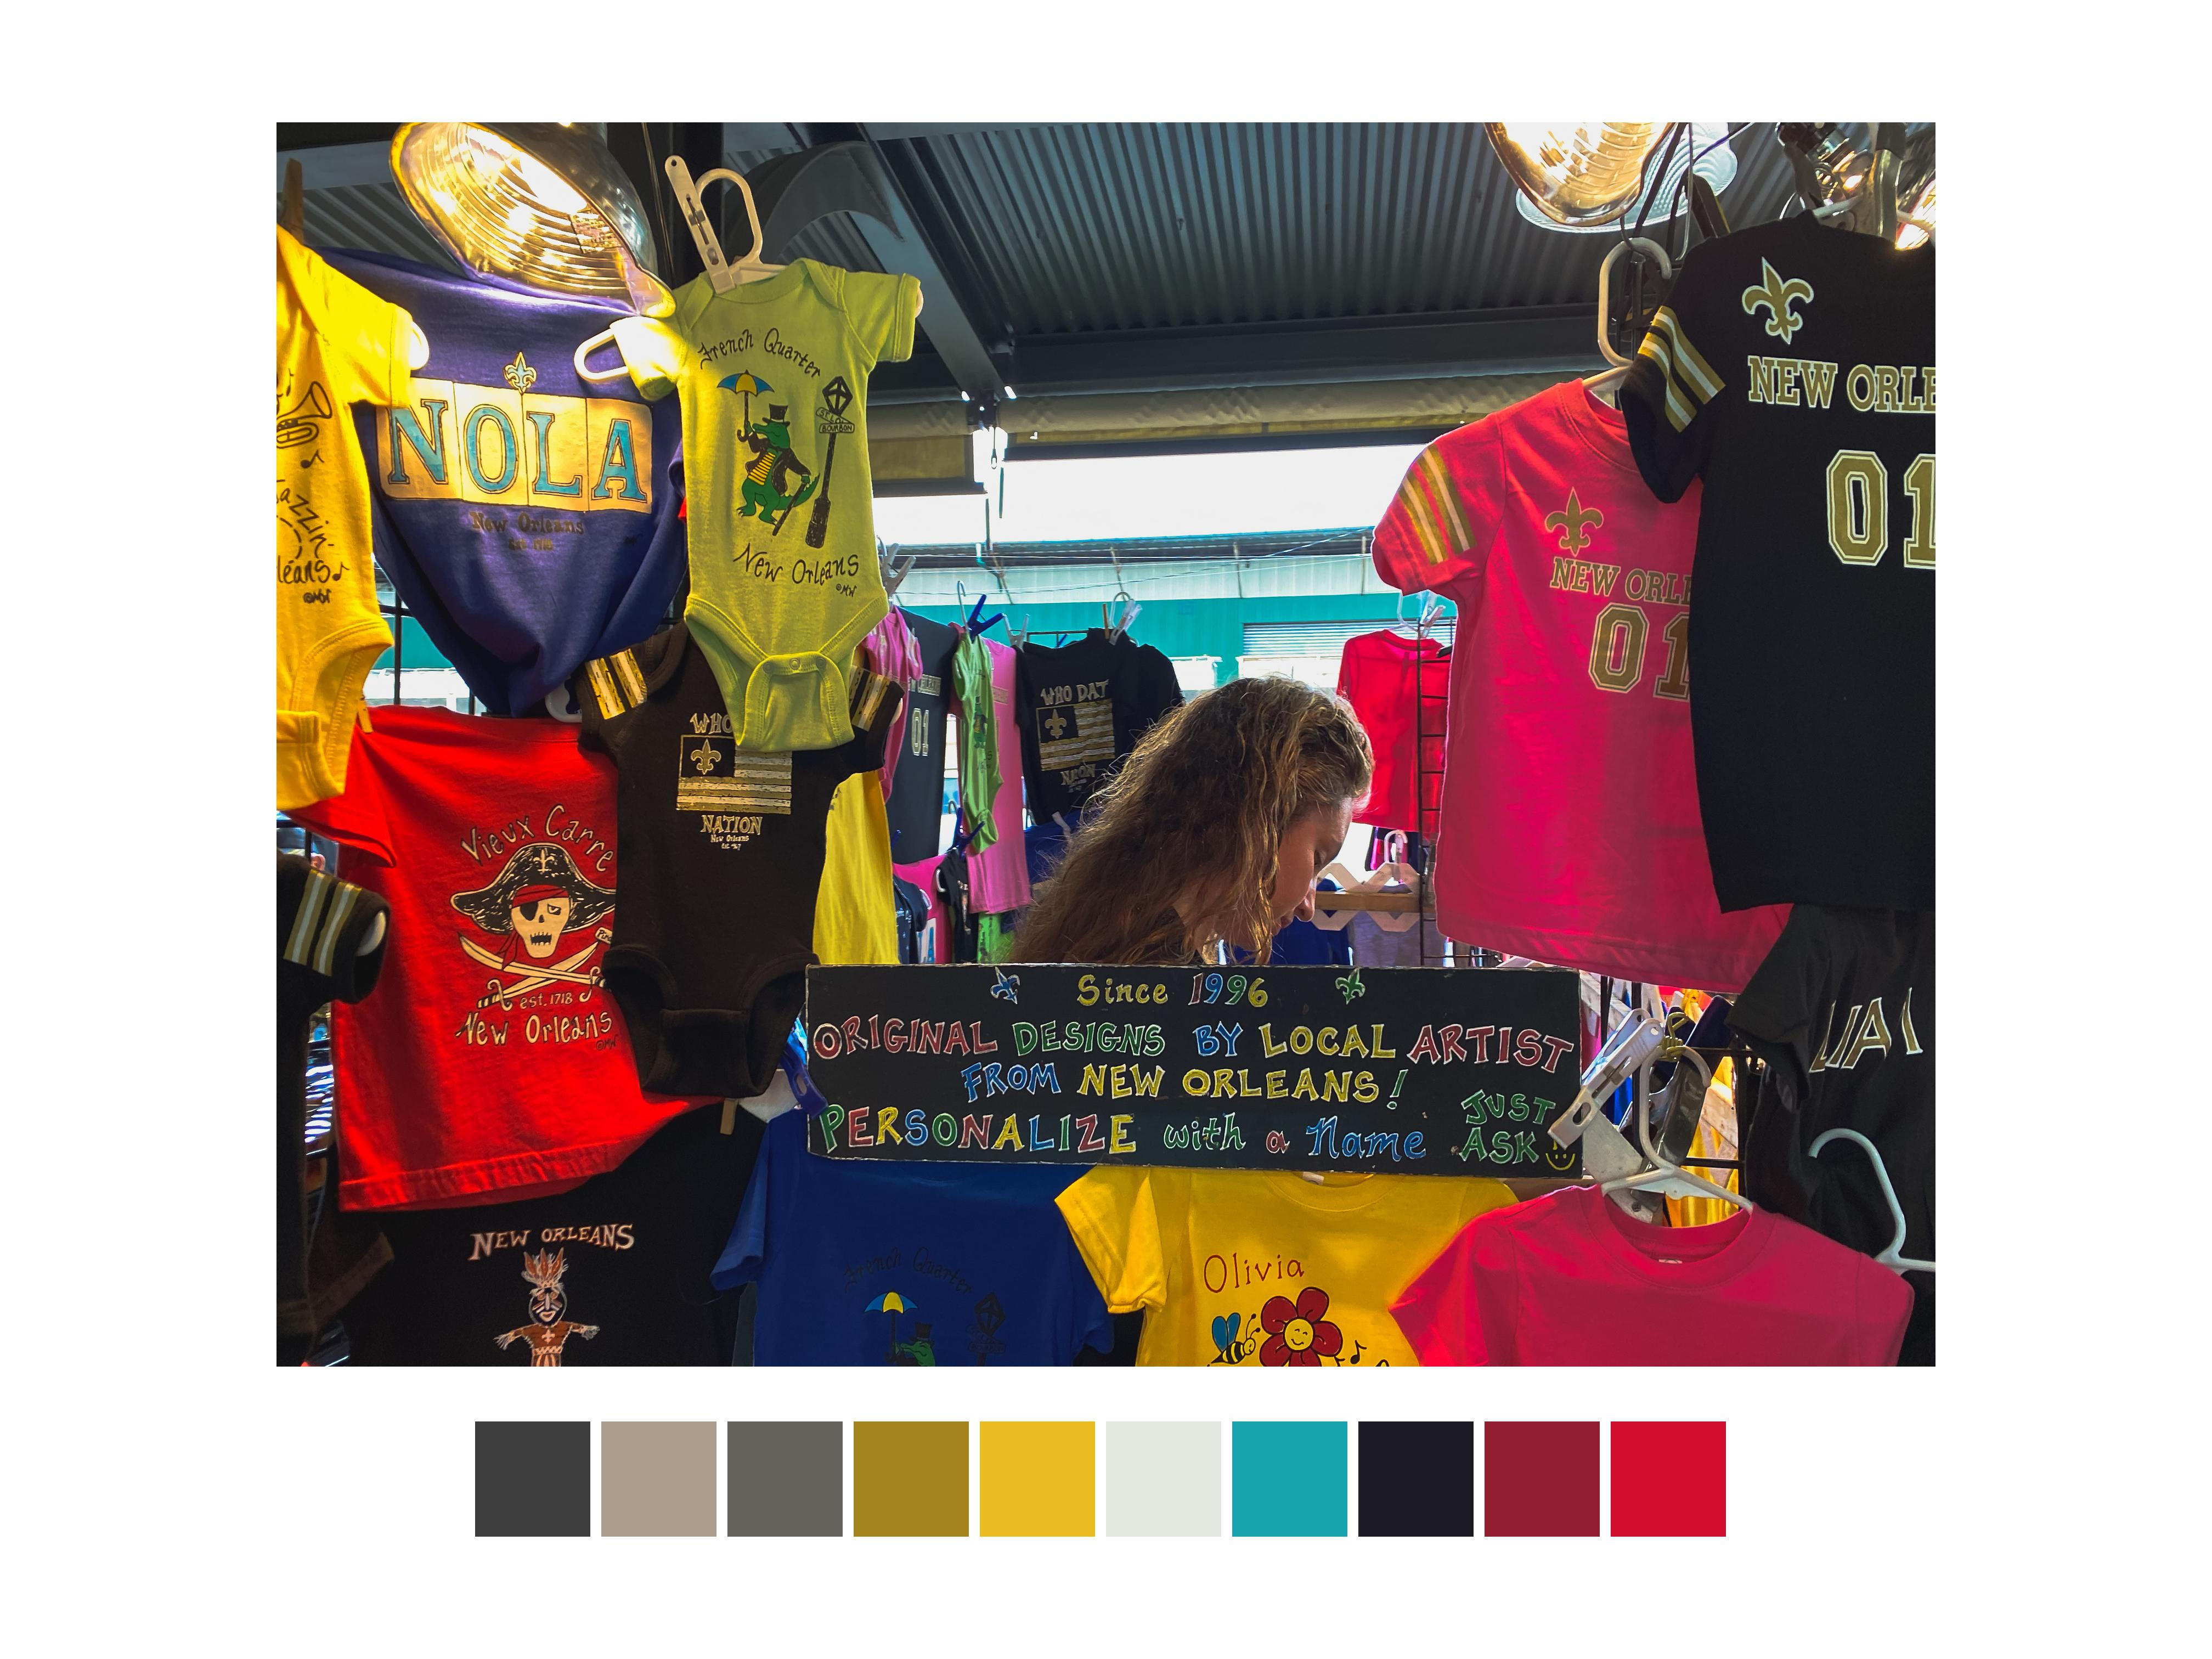

In [38]:
from IPython.display import Image
Image(filename='test_palette.jpg') 

* 3D scatter graf dat z obrázku, obarvený podle jednotlivých shluků

Text(0.5, 0, '2 attribute')

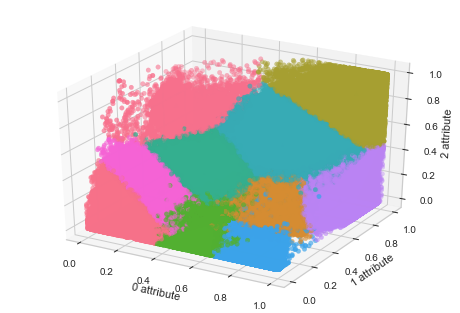

In [39]:
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.scatter(image_array[:,0], image_array[:,1], image_array[:,2], cmap=cmap, c=km.labels_)

ax.scatter(km.cluster_centers_[:, 0],km.cluster_centers_[:, 1],km.cluster_centers_[:, 2], marker='^')

ax.set_xlabel('0 attribute')
ax.set_ylabel('1 attribute')
ax.set_zlabel('2 attribute')

* Interativní verze 3D scatter grafu dat z obrázku, obarvených podle jednotlivých shluků

<IPython.core.display.Javascript object>


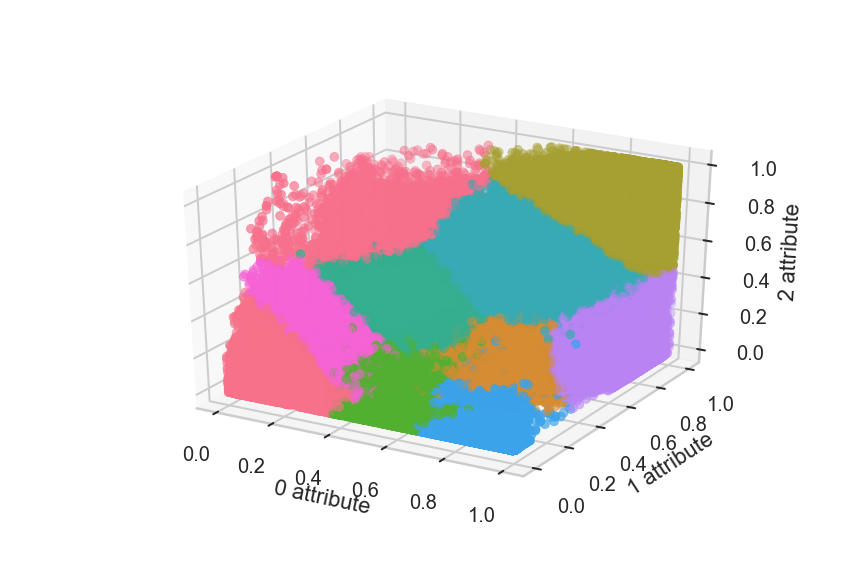

Text(0.5, 0, '2 attribute')

In [41]:
%matplotlib notebook
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import axes3d   

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.scatter(image_array[:,0], image_array[:,1], image_array[:,2], cmap=cmap, c=km.labels_)

ax.scatter(km.cluster_centers_[:, 0],km.cluster_centers_[:, 1],km.cluster_centers_[:, 2], marker='^')

ax.set_xlabel('0 attribute')
ax.set_ylabel('1 attribute')
ax.set_zlabel('2 attribute')